In [41]:
# Library
import os
import random
import pickle
import gc
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import shap
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import font_manager, rc
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans, MiniBatchKMeans
# from category_encoders import TargetEncoder
from sklearn.preprocessing import (
    StandardScaler, PowerTransformer, OrdinalEncoder,
    OneHotEncoder, FunctionTransformer, PolynomialFeatures, LabelEncoder, MinMaxScaler
)
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, RFE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso,
    SGDRegressor, ElasticNet
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_validate,
    GridSearchCV, KFold, cross_val_predict
)
from sklearn.metrics import (
    roc_auc_score, mean_squared_error, make_scorer, accuracy_score, log_loss
)
from sklearn import set_config, datasets
from catboost import (
    CatBoostRegressor, CatBoostClassifier,
)
# import category_encoders as ce
# from sklearn.pipeline import (
#     Pipeline, FeatureUnion, make_pipeline
# )
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, StackingRegressor,
    GradientBoostingRegressor, VotingClassifier, VotingRegressor,
    HistGradientBoostingRegressor, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier, RandomForestRegressor,ExtraTreesRegressor
)
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC, SVR, LinearSVC
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

import xgboost as xgb
import lightgbm as lgb
import re
import math
import optuna

from scipy.stats import zscore

%matplotlib inline

warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)
pd.set_option('display.max_columns', None)

In [42]:
df = pd.read_pickle('matches_df.pkl')

## Preprocessing

In [43]:
X = df
y = df['home_team_result']

# split_index = 1796 # 2021년도까지의 index

# train = X.iloc[:split_index]
# test = X.iloc[split_index:]
# y_train = y.iloc[:split_index]
# y_test = y.iloc[split_index:]


train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## 이 방법에 의문을 품는 바이요!!

In [44]:
def team_encoding(train):
    train['home_win'] = train['home_team_result'].apply(lambda x: 1 if x=='승' else 0) # home_win 열 추가, 승리인 경우 1, 아닌 경우 0
    dic = {}
    # 각 홈팀별 이긴 경기 수를 딕셔너리에 저장
    for team in train['home_team_name'].unique():
        value = train[train['home_team_name'] == team]['home_win'].sum() 
        #home_team_name  열에서 고유한 팀 이름을 가져와 각 팀이 홈에서 이긴 경기 수 계산, 이 값을 dic에 저장
        dic[team] = value

    label_dic={}
    # 승리 횧수를 기준으로 오름차순 정렬, 각 팀에 대해 라벨 부여, 승리 횟수가 적은 팀부터 0,1,2 의 라벨을 부여
    for idx, (team, _) in enumerate(sorted(dic.items(), key= lambda x: x[1])):
        label_dic[team] = idx
    
    return label_dic


''' 홈팀 득점 이동평균 계산 함수 '''

def homeGoal_day_mean(train, test, day):
    train[f'home_Goal_{day}_mean'] = -1  # 초기값 -1로 설정
    test[f'home_Goal_{day}_mean'] = -1
    
    teams = train['home_team_name'].unique()
    for team in tqdm(teams): # train에서 고유 팀 이름을 가져오고 이를 시각적으로 표시해줌 : tqdm
        team_df = train[train['home_team_name'] == team]
        # 롤링 윈도우 크기 설정
        ch_day = len(team_df) if len(team_df) < day else day # 팀의 경기 수가 주어진 day 보다 적으면, 경기 수 만큼의 윈도우 크기 사용
        idx = team_df['home_team_goal_count'].rolling(ch_day).mean().index.values # 롤링 윈도우 평균 계산
        val = team_df['home_team_goal_count'].rolling(ch_day).mean().values
        train[f'home_Goal_{day}_mean'].loc[idx] = val
        test_idx = test[test['home_team_name'] == team].index
        test[f'home_Goal_{day}_mean'].loc[test_idx] = val[-1]
    # 결측값 처리
    train[f'home_Goal_{day}_mean'] = train[f'home_Goal_{day}_mean'].fillna(0)


''' 원정팀 득점 이동평균 계산 함수 '''

def awayGoal_day_mean(train, test, day):
    # 초기값 설정
    train[f'away_Goal_{day}_mean'] = -1
    test[f'away_Goal_{day}_mean'] = -1
    
    teams = train['away_team_name'].unique()
    for team in tqdm(teams):
        team_df = train[train['away_team_name'] == team]
        # 롤링 윈도우 크기 설정
        ch_day = len(team_df) if len(team_df) < day else day
        idx = team_df['away_team_goal_count'].rolling(ch_day).mean().index.values
        val = team_df['away_team_goal_count'].rolling(ch_day).mean().values
        train[f'away_Goal_{day}_mean'].loc[idx] = val
        test_idx = test[test['away_team_name'] == team].index
        test[f'away_Goal_{day}_mean'].loc[test_idx] = val[-1]
    # 결측값 처리
    train[f'away_Goal_{day}_mean'] = train[f'away_Goal_{day}_mean'].fillna(0)


'''홈팀 승리율 평균 계산 함수'''

def homeWin_day_mean(train, test, day):
    train[f'home_winRate_{day}_mean'] = -1
    test[f'home_winRate_{day}_mean'] = -1
    train['win'] = train['home_team_result'].apply(lambda x: 1 if x == '승' else 0)

    teams = train['home_team_name'].unique()
    for team in tqdm(teams):
        team_df = train[train['home_team_name'] == team]
        ch_day = len(team_df) if len(team_df) < day else day
        idx = team_df['win'].rolling(ch_day).mean().index.values
        val = team_df['win'].rolling(ch_day).mean().values
        train[f'home_winRate_{day}_mean'].loc[idx] = val
        test_idx = test[test['home_team_name'] == team].index
        test[f'home_winRate_{day}_mean'].loc[test_idx] = val[-1]

    train.drop(columns=['win'], inplace=True)

    train[f'home_winRate_{day}_mean'] = train[f'home_winRate_{day}_mean'].fillna(0)


'''원정팀 승리율 평균 계산 함수'''

def awayWin_day_mean(train, test, day):

    train[f'away_winRate_{day}_mean'] = -1
    test[f'away_winRate_{day}_mean'] = -1
    train['win'] = train['home_team_result'].apply(lambda x: 1 if x == '패' else 0)
    
    teams = train['away_team_name'].unique()
    for team in tqdm(teams):
        team_df = train[train['away_team_name'] == team]

        ch_day = len(team_df) if len(team_df) < day else day
        idx = team_df['win'].rolling(ch_day).mean().index.values
        val = team_df['win'].rolling(ch_day).mean().values
        train[f'away_winRate_{day}_mean'].loc[idx] = val
        test_idx = test[test['away_team_name'] == team].index
        test[f'away_winRate_{day}_mean'].loc[test_idx] = val[-1]

    train.drop(columns=['win'], inplace=True)

    train[f'away_winRate_{day}_mean'] = train[f'away_winRate_{day}_mean'].fillna(0)


'''홈팀 평균 계산 함수'''

def home_day_mean(train, test, columns, day):
    for column in tqdm(columns):
        teams = train['home_team_name'].values
        train[f'home_{column}_{day}_mean'] = -1
        test[f'home_{column}_{day}_mean'] = -1

        for team in tqdm(teams):
            team_df = train[train['home_team_name'] == team]
            idx = team_df[column].rolling(day).mean().index.values
            val = team_df[column].rolling(day).mean().values
            train[f'home_{column}_{day}_mean'].loc[idx] = val
            test_idx = test[test['home_team_name'] == team].index
            test[f'home_{column}_{day}_mean'].loc[test_idx] = val[-1]

        train[f'home_{column}_{day}_mean'] = train[f'home_{column}_{day}_mean'].fillna(0)
        test[f'home_{column}_{day}_mean'] = test[f'home_{column}_{day}_mean'].fillna(0)


'''원정팀 평균 계산 함수'''

def away_day_mean(train, test, columns, day):
    for column in tqdm(columns):
        teams = train['away_team_name'].values
        train[f'away_{column}_{day}_mean'] = -1
        test[f'away_{column}_{day}_mean'] = -1

        for team in tqdm(teams):
            team_df = train[train['away_team_name'] == team]
            idx = team_df[column].rolling(day).mean().index.values
            val = team_df[column].rolling(day).mean().values
            train[f'away_{column}_{day}_mean'].loc[idx] = val
            test_idx = test[test['away_team_name'] == team].index
            test[f'away_{column}_{day}_mean'].loc[test_idx] = val[-1]

        train[f'away_{column}_{day}_mean'] = train[f'away_{column}_{day}_mean'].fillna(0)
        test[f'away_{column}_{day}_mean'] = test[f'away_{column}_{day}_mean'].fillna(0)


'''전처리 함수'''

def preprocessing(train, test, dic):
    # 년과 월일로 나누기
    train['date_GMT'] = train['date_GMT'].dt.strftime('%Y%m%d')
    test['date_GMT'] = test['date_GMT'].dt.strftime('%Y%m%d')
    train['year'] = train['date_GMT'].apply(lambda x : int(x[0:4]))
    # train['month'] = train['date_GMT'].apply(lambda x : int(x[5:7]))
    # train['day'] = train['date_GMT'].apply(lambda x : int(x[8:10]))

    test['year'] = test['date_GMT'].apply(lambda x : int(x[0:4]))
    # test['month'] = test['date_GMT'].apply(lambda x : int(x[5:7]))
    # test['day'] = test['date_GMT'].apply(lambda x : int(x[8:10]))
    train.drop(columns=['date_GMT'], inplace=True)
    test.drop(columns=['date_GMT'], inplace=True)

    # 팀 인코딩 적용
    label_dic = dic
    train['home_team_name'] = train['home_team_name'].apply(lambda x: label_dic[x])
    train['away_team_name'] = train['away_team_name'].apply(lambda x: label_dic[x])
    test['home_team_name'] = test['home_team_name'].apply(lambda x: label_dic[x])
    test['away_team_name'] = test['away_team_name'].apply(lambda x: label_dic[x])

    # 5일간 홈팀 승리 비율 계산
    homeWin_day_mean(train, test, 5)
    # 5일간 원정팀 승리 비율 계산
    awayWin_day_mean(train, test, 5)

    # 5일간 홈팀 평균 득점 계산
    homeGoal_day_mean(train, test, 5)
    # 5일간 원정팀 평균 득점 계산
    awayGoal_day_mean(train, test, 5)

    # 불필요한 컬럼 제거
    # train = train.drop(columns=['home_win', 'index','home_team_goal_count','away_team_goal_count','home_team_result','game_points'])
    train = train.drop(columns=['home_win', 'index','home_team_goal_count','away_team_goal_count','game_points'])
    test = test.drop(columns=['index','home_team_goal_count','away_team_goal_count','home_team_result','game_points'])

    return train, test


## Train / Test

In [45]:
hometeam_list = list(train['home_team_name'].unique())
dic = team_encoding(train)
train, test= preprocessing(train, test, dic)
test_idx = test.index.values


# 승무패 인코딩
lec = LabelEncoder()
lec.fit(df['home_team_result'])
y_train = lec.transform(y_train)
y_test = lec.transform(y_test)

100%|██████████| 17/17 [00:00<00:00, 570.13it/s]


In [46]:
# # 홈팀과 원정팀의 공격 효율성을 계산한 피쳐 생성
# train['home_attack_efficiency'] = train['home_Goal_5_mean'] * train['home_team_shots_on_target']
# train['away_attack_efficiency'] = train['away_Goal_5_mean'] * train['away_team_shots_on_target']
# # 홈팀과 원정팀의 공격 효율성 차이를 나타내는 피쳐 생성
# train['attack_efficiency_difference'] = train['home_attack_efficiency'] - train['away_attack_efficiency']

# # 최근 5경기 평균 득점의 표준 편차를 나타내는 피쳐 생성
# train['home_Goal_5_std'] = train['home_Goal_5_mean'].rolling(window=5).std()
# train['away_Goal_5_std'] = train['away_Goal_5_mean'].rolling(window=5).std()

# # 결측값을 0으로 대체
# train = train.fillna(0)

# # 테스트 데이터에도 동일한 피쳐 생성
# test['home_attack_efficiency'] = test['home_Goal_5_mean'] * test['home_team_shots_on_target']
# test['away_attack_efficiency'] = test['away_Goal_5_mean'] * test['away_team_shots_on_target']
# test['attack_efficiency_difference'] = test['home_attack_efficiency'] - test['away_attack_efficiency']
# test['home_Goal_5_std'] = test['home_Goal_5_mean'].rolling(window=5).std()
# test['away_Goal_5_std'] = test['away_Goal_5_mean'].rolling(window=5).std()
# test = test.fillna(0)

# 학습 데이터에서 목표 변수 'home_team_result' 컬럼 제거
train.drop(columns = ['home_team_result'], inplace = True)


In [47]:
# import sweetviz as sv

# report = sv.analyze(train)
# report.show_html("new_features.html")

## Feature scaler

In [48]:
cat = ['home_team_name','away_team_name','year','month']

num_features = list(set(train.columns) - set(cat))
# scaler = MinMaxScaler()
scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

## Over-Sampling

In [49]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import pandas as pd
from collections import Counter

# SMOTE 객체 생성 (각 클래스의 샘플 수를 1000개로 설정)
smote = SMOTE(sampling_strategy={0: 5000, 1: 5000, 2: 5000}, random_state=42)

# SMOTE-Tomek 객체 생성
smote_tomek = SMOTETomek(smote=smote, random_state=42)

# 오버샘플링 및 언더샘플링 적용
train_resampled, y_train_resampled = smote_tomek.fit_resample(train, y_train)

# 각 클래스 비율 확인
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

print(f"Original training set shape: {train.shape}")
print(f"Resampled training set shape: {train_resampled.shape}")

Resampled class distribution: Counter({0: 5000, 2: 5000, 1: 5000})
Original training set shape: (1984, 28)
Resampled training set shape: (15000, 28)


## Shap

### xgb

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
import shap
SHAP_THRESHOLD = 0.05

# feature_names dimension 조정
train_col = train.columns
feature_names = train_col.to_numpy()

# 모델 학습
model = xgb.XGBClassifier().fit(train_resampled, y_train_resampled)

# 모델 예측 및 평가
y_pred = model.predict(test)
print("Validation Accuracy:", accuracy_score(y_test, y_pred))

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

# SHAP 값 요약
if isinstance(shap_values, list):  # shap_values가 리스트일 경우 (XGBoost >= 1.0.0)
    shap_values = shap_values[1]

shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({'column_name': feature_names, 'shap_importance': shap_sum})
importance_df = importance_df.sort_values('shap_importance', ascending=False)

# 중요도 임계값 적용 (선택 사항)
importance_df_filtered = importance_df[importance_df['shap_importance'] > SHAP_THRESHOLD]
print("Filtered SHAP Importances:\n", importance_df_filtered)

Validation Accuracy: 0.5745967741935484
Filtered SHAP Importances:
                        column_name  shap_importance
24             home_winRate_5_mean         1.148316
16  home_team_goal_count_half_time         0.938362
22                  5_games_result         0.799518
6        home_team_shots_on_target         0.787372
17  away_team_goal_count_half_time         0.671943
7        away_team_shots_on_target         0.299008
25             away_winRate_5_mean         0.256602
26                home_Goal_5_mean         0.243335
10            home_team_possession         0.239132
1                   away_team_name         0.208636
0                   home_team_name         0.206982
4                  home_team_shots         0.148275
9                  away_team_fouls         0.139383
21             away_team_red_cards         0.139369
15               away_team_offside         0.137519
11            away_team_possession         0.126546
2           home_team_corner_count         0.118

In [51]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
shap_xgb_train_resampled = train_resampled[features_selected]
shap_xgb_test = test[features_selected]

### lgbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6420
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 28
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Validation Accuracy: 0.5665322580645161


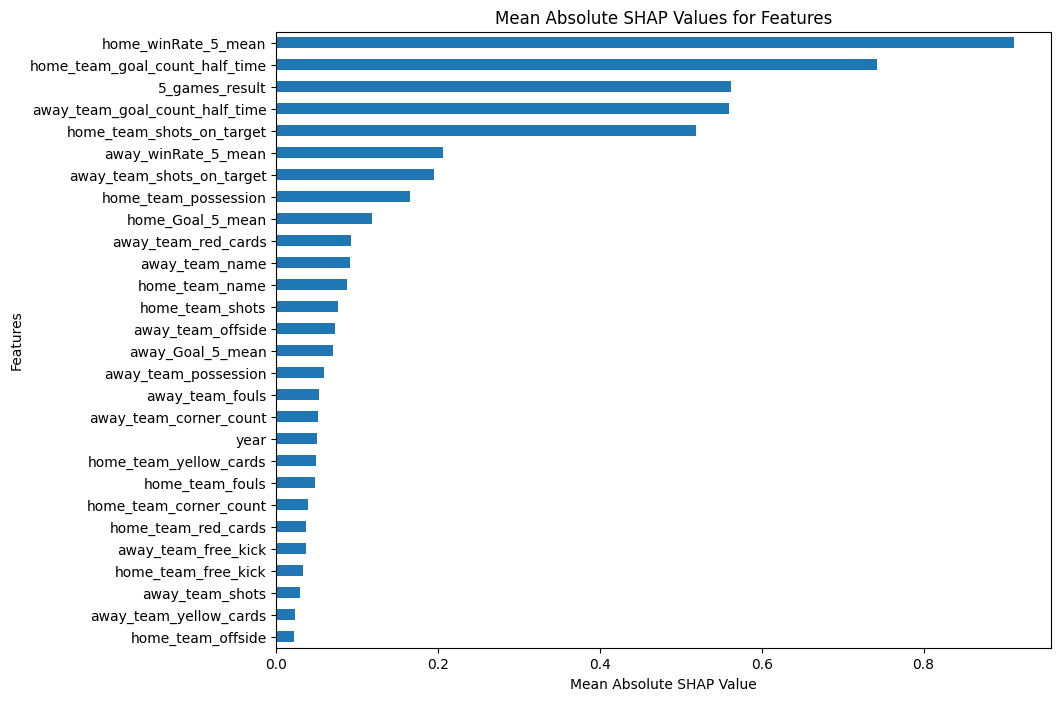

In [52]:
# LightGBM 모델 학습
model = lgb.LGBMClassifier().fit(train_resampled, y_train_resampled)
SHAP_THRESHOLD = 0.1

# 모델 예측 및 평가
y_pred = model.predict(test)
print("Validation Accuracy:", accuracy_score(y_test, y_pred))

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False);
# importance_df

# # SHAP 값 데이터프레임 생성 (각 피쳐별 SHAP 값)
# shap_values_df = pd.DataFrame(shap_values[1], columns=test.columns)
# shap_values_df

# SHAP 값의 평균 절대값 계산
shap_abs_mean = pd.DataFrame(shap_values[1], columns=test.columns).abs().mean().sort_values(ascending=False)

# SHAP 값 평균 절대값 시각화
plt.figure(figsize=(10, 8))
shap_abs_mean.plot(kind='barh')
plt.title("Mean Absolute SHAP Values for Features")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

In [53]:
# 지정된(SHAP_THRESHOLD) Shap feature 중요도 이상인 것만 선택
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
shap_lgbm_train_resampled = train_resampled[features_selected]
shap_lgbm_test = test[features_selected]

## model Oputna

### xgb

In [54]:
# xgboostclassifier
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def xgb_objective(trial):
    # 하이퍼파라미터 범위 설정
    max_depth = trial.suggest_int('max_depth', 3, 7)  # max_depth의 범위를 줄임
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # n_estimators의 범위를 줄임
    subsample = trial.suggest_float('subsample', 0.5, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.9)
    min_child_weight = trial.suggest_int('min_child_weight', 4, 10)  # 추가
    gamma = trial.suggest_float('gamma', 0, 5)  # 추가
    
    # XGBClassifier 모델 정의
    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,  # 추가
        gamma=gamma,  # 추가
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # 교차 검증 점수 계산
    scores = cross_val_score(clf, shap_xgb_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    
    return scores.mean()

# Optuna 스터디 생성 및 최적화
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50)  # 최적화 반복 횟수는 필요에 따라 조절

# 최적 하이퍼파라미터 출력
xgb_best_params = xgb_study.best_params
print(' ')
print(xgb_best_params)

[I 2024-07-02 20:31:41,488] A new study created in memory with name: no-name-f6a4b280-8e11-49f7-b2b1-f5488c307f11
[I 2024-07-02 20:31:44,022] Trial 0 finished with value: 0.7973333333333332 and parameters: {'max_depth': 6, 'learning_rate': 0.00012187983837867963, 'n_estimators': 121, 'subsample': 0.8959961711550594, 'colsample_bytree': 0.5750459966531851, 'min_child_weight': 10, 'gamma': 0.6723491266982701}. Best is trial 0 with value: 0.7973333333333332.
[I 2024-07-02 20:31:46,768] Trial 1 finished with value: 0.7998666666666667 and parameters: {'max_depth': 6, 'learning_rate': 0.00013305754542387163, 'n_estimators': 129, 'subsample': 0.5715925503412516, 'colsample_bytree': 0.5887776211102034, 'min_child_weight': 4, 'gamma': 0.19261007973354116}. Best is trial 1 with value: 0.7998666666666667.
[I 2024-07-02 20:31:47,959] Trial 2 finished with value: 0.7304666666666667 and parameters: {'max_depth': 4, 'learning_rate': 0.0042095730332011964, 'n_estimators': 102, 'subsample': 0.716151855

 
{'max_depth': 7, 'learning_rate': 0.004782347272878005, 'n_estimators': 67, 'subsample': 0.785181706732375, 'colsample_bytree': 0.5174718925912217, 'min_child_weight': 4, 'gamma': 2.073635700349996}


In [55]:
model_logis=xgb.XGBClassifier(**xgb_best_params)
# model_logis=xgb.XGBClassifier(max_depth= 4, learning_rate= 0.00020353095689003422, n_estimators= 229, subsample= 0.5217582675029752, colsample_bytree= 0.5421399627551824)
model_logis.fit(shap_xgb_train_resampled, y_train_resampled)
y_pred = model_logis.predict(shap_xgb_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy=", accuracy)

Accuracy= 0.5987903225806451


### Logisticregression

In [36]:
# LogisticRegression
def logreg_objective(trial):
    
    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 1e-4, 1e2, log=True)
     
    clf =  LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
    scores = cross_val_score(clf, shap_lgbm_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    
    return scores.mean()
    
logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(logreg_objective, n_trials=5)

logreg_best_params = logreg_study.best_params

[I 2024-06-28 21:54:38,602] A new study created in memory with name: no-name-2aff2b9a-2fe7-4dcf-92f6-6d5f1e2b3bd2
[I 2024-06-28 21:55:49,292] Trial 0 finished with value: 0.7284666666666666 and parameters: {'l1_ratio': 0.2856138499871832, 'C': 0.0037205809861660137}. Best is trial 0 with value: 0.7284666666666666.
[I 2024-06-28 21:57:40,823] Trial 1 finished with value: 0.7453333333333333 and parameters: {'l1_ratio': 0.3056108275229963, 'C': 1.6419178967802188}. Best is trial 1 with value: 0.7453333333333333.
[I 2024-06-28 21:58:16,770] Trial 2 finished with value: 0.5116666666666666 and parameters: {'l1_ratio': 0.6061286699922386, 'C': 0.0002657614048158736}. Best is trial 1 with value: 0.7453333333333333.
[I 2024-06-28 21:59:51,442] Trial 3 finished with value: 0.7392000000000001 and parameters: {'l1_ratio': 0.8505460243217602, 'C': 0.013509837949129862}. Best is trial 1 with value: 0.7453333333333333.
[I 2024-06-28 22:00:38,313] Trial 4 finished with value: 0.717 and parameters: {'l

In [37]:
model_logis=LogisticRegression(**logreg_best_params)
model_logis.fit(shap_lgbm_train_resampled,y_train_resampled)
y_pred = model_logis.predict(shap_lgbm_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5511695906432749


## Randomforest feature selection  큰 효과가 없는 듯 함

In [ ]:
# model = RandomForestClassifier()
# model.fit(train_resampled, y_train_resampled)
# y_pred = model.predict(test)

# rn_features = []
# importances = model.feature_importances_
# feature_names = train.columns

# # 피처 중요도를 기준으로 정렬하여 상위 피처 선택
# indices = np.argsort(importances)[::-1]

# # 중요도가 0.01 이상인 피처만 선택
# # top_number = 40
# top_num_indices = [idx for idx in indices if importances[idx] >= 0.005] #[:top_number]
# top_features = feature_names[top_num_indices]

# for i, feature in enumerate(top_features):
#     print(f"{i+1}. {feature} (중요도: {importances[top_num_indices[i]]})")
#     rn_features.append(feature)

# rn_train_resampled = train_resampled[rn_features]
# rn_test = test[rn_features]

# model_logis=LogisticRegression(**logreg_best_params)
# model_logis.fit(rn_train_resampled,y_train_resampled)
# y_pred = model_logis.predict(rn_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

## 상관계수 계산

In [ ]:
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_number = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > corr_number)]
to_drop
# # 특징 제거
corr_train_resampled = train_resampled.drop(columns=to_drop)  
corr_test = test.drop(columns=to_drop)

In [ ]:
def logreg_objective(trial):
    
    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 1e-4, 1e2, log=True)
     
    clf =  LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
    scores = cross_val_score(clf, corr_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    
    return scores.mean()
    
logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(logreg_objective, n_trials=5)

logreg_best_params = logreg_study.best_params


In [ ]:
model_logis=LogisticRegression(**logreg_best_params)
model_logis.fit(corr_train_resampled,y_train_resampled)
y_pred = model_logis.predict(corr_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

## L1 규제(Lasso)

In [ ]:
# alpha 값 후보군 설정
alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100]
param_grid = {'alpha': alpha_values}

# Lasso 모델과 GridSearchCV 설정
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

# 최적의 alpha 값 찾기
grid_search.fit(train_resampled, y_train_resampled)
best_alpha = grid_search.best_params_['alpha']
best_alpha

In [ ]:
lasso = Lasso(alpha=best_alpha)  # 위에서 나온 alpha 값으로 조정한 거임
lasso.fit(train_resampled, y_train_resampled)

# 가중치가 0이 아닌 특징 선택
selected_features = train_resampled.columns[lasso.coef_ != 0]
selected_features

In [ ]:
L1_train_resampled = train_resampled[selected_features]
L1_test = test[selected_features]

In [ ]:
def logreg_objective(trial):
    
    r = trial.suggest_float('l1_ratio', 0, 1, log=False)
    c = trial.suggest_float('C', 1e-4, 1e2, log=True)
     
    clf =  LogisticRegression(max_iter=5000, solver='saga', penalty='elasticnet', l1_ratio=r, C=c)
    scores = cross_val_score(clf, L1_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
    
    return scores.mean()
    
logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(logreg_objective, n_trials=5)

logreg_best_params = logreg_study.best_params

## model select

In [ ]:
model_logis=LogisticRegression(**logreg_best_params)
model_logis.fit(L1_train_resampled,y_train_resampled)

y_pred = model_logis.predict(L1_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
# model.fit(train, y_train) 
# y_pred = model.predict(test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# 2013~2023  
### 많긴 하지만 정확도 떨어질 것으로 예상됨

# 2020~2023
### 데이터 수가 급격히 줄어듬